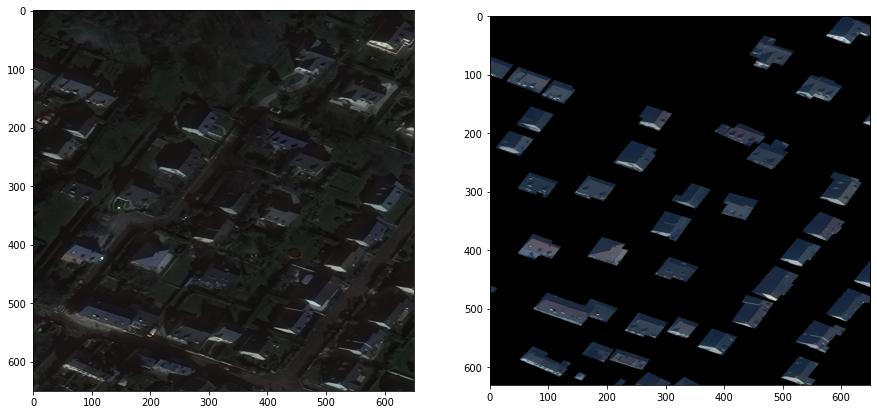

In [1]:
import os
import re

import numpy as np
from rasterio.mask import mask, raster_geometry_mask
import rasterio.plot
from matplotlib import pyplot as plt
import fiona

filename = "AOI_3_Paris_img656"

with fiona.open(f"./AOI_3_Paris_Train/geojson/buildings/buildings_{filename}.geojson") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(f"./AOI_3_Paris_Train/RGB-PanSharpen/RGB-PanSharpen_{filename}.tif") as src:
    img = src.read((3, 2, 1))
    mask_img, transform = mask(src, shapes, crop=True)
    mask = raster_geometry_mask(src, shapes)[0]
    meta = src.meta

def normalise(im):
    img_max = im.max(axis=(1, 2)).reshape(-1, 1, 1)
    img_min = im.min(axis=(1, 2)).reshape(-1, 1, 1)
    return (((im - img_min) / (img_max - img_min)) * 255).astype(np.ubyte).transpose(1, 2, 0)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(normalise(img))
axs[1].imshow(normalise(mask_img))

In [2]:
import torch
import torch.utils.data
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, random_split

print("CUDA working:", torch.cuda.is_available())


class SpacenetDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(".tif")]
        self.transform = transform
        self.target_transform = target_transform
        
    def load_data(img_dir, label_dir):
        r = []
        for f in os.listdir(img_dir):
            if not f.endswith(".tif"):
                continue
            f_filename = re.sub(r"\.tif$", ".geojson", f)
            f_filename = re.sub(r"RGB-PanSharpen_", "buildings_", f_filename)
            f_shape = os.path.join(label_dir, f_filename)
            if not f_shape:
                continue
            with fiona.open(f_shape) as fp_shape:
                shapes = [feature["geometry"] for feature in fp_shape]
            with rasterio.open(os.path.join(img_dir, f)) as src:
                img = src.read((3, 2, 1))
                mask = raster_geometry_mask(src, shapes)[0] if len(shapes) > 0 else np.zeros(img.shape)
                img = normalise(img)
                r.append((img, mask))
        return r

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_filename = self.img_files[idx]
        mask_filename = re.sub(r"\.tif$", ".geojson", img_filename)
        mask_filename = re.sub(r"RGB-PanSharpen_", "buildings_", mask_filename)
        
        mask_filepath = os.path.join(self.mask_dir, mask_filename)
        img_filepath = os.path.join(self.img_dir, img_filename)
        
        with fiona.open(mask_filepath) as mask_shape:
            shapes = [feature["geometry"] for feature in mask_shape]
        with rasterio.open(img_filepath) as src:
            img = src.read((3, 2, 1))
            mask = raster_geometry_mask(src, shapes)[0] if len(shapes) > 0 else np.zeros(img.shape[1:3]).astype(bool)
            img = normalise(img)
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        return img, mask.astype(np.double)
    
transform = transforms.Compose(
    [
        transforms.ToTensor(),      
    ]
)

train_test_split = 0.9
dataset = SpacenetDataset("./AOI_3_Paris_Train/RGB-PanSharpen", "./AOI_3_Paris_Train/geojson/buildings", transform=transform)
split_index = int(len(dataset) * train_test_split)
train_dataset, test_dataset = random_split(dataset, [split_index, len(dataset) - split_index])
dataset[0][0].shape

CUDA working: True


torch.Size([3, 650, 650])

In [3]:
BATCH_SIZE = 10

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [4]:
from torch import nn
import torch.nn.functional as F


class CNNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        self.conv3 = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x.squeeze(dim=1)

net = CNNNet()

In [5]:
from torch import optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 10

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, d in enumerate(trainloader):
        inputs, masks = d
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0

[1,    10] loss: 0.691
[1,    20] loss: 0.673
[1,    30] loss: 0.666
[1,    40] loss: 0.674
[1,    50] loss: 0.660
[1,    60] loss: 0.660
[1,    70] loss: 0.661
[1,    80] loss: 0.637
[1,    90] loss: 0.652
[1,   100] loss: 0.638
[2,    10] loss: 0.636
[2,    20] loss: 0.608
[2,    30] loss: 0.616
[2,    40] loss: 0.654
[2,    50] loss: 0.597
[2,    60] loss: 0.603
[2,    70] loss: 0.600
[2,    80] loss: 0.620
[2,    90] loss: 0.605
[2,   100] loss: 0.584
[3,    10] loss: 0.627
[3,    20] loss: 0.599
[3,    30] loss: 0.609
[3,    40] loss: 0.627
[3,    50] loss: 0.592
[3,    60] loss: 0.572
[3,    70] loss: 0.591
[3,    80] loss: 0.555
[3,    90] loss: 0.611
[3,   100] loss: 0.571
[4,    10] loss: 0.540
[4,    20] loss: 0.588
[4,    30] loss: 0.637
[4,    40] loss: 0.558
[4,    50] loss: 0.617
[4,    60] loss: 0.622
[4,    70] loss: 0.576
[4,    80] loss: 0.602
[4,    90] loss: 0.584
[4,   100] loss: 0.575
[5,    10] loss: 0.619
[5,    20] loss: 0.589
[5,    30] loss: 0.493
[5,    40] 